# Spectrum represenation

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import itertools
import logging
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from ann_solo import reader, spectral_library, writer
from ann_solo.config import config

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

# initialize logging
logging.basicConfig(format='%(asctime)s [%(levelname)s/%(processName)s] '
                           '%(module)s.%(funcName)s : %(message)s',
                    level=logging.INFO)

In [4]:
splib_filename = '../data/processed/iprg2012/human_yeast_targetdecoy.splib'
mgf_filename = '../data/external/iPRG2012.mgf'
out_dir = '../data/processed/iprg2012/spectrum_representation'

We consider the following options for the representation of MS2 spectra:

- The number of peaks: ranging from 25 to 150 in steps of 25.
- The intensity scaling: either square root scaling or rank scaling.

These representation options are evaluated based on the identification performance in terms of the number of PSMs at a 1% FDR.

Search settings:

- Query file: spectra generated for the [iPRG 2012 study](http://www.mcponline.org/cgi/doi/10.1074/mcp.M113.032813).
- Precursor mass tolerance: 20 ppm
- Fragment mass tolerance: 0.25 Da

In [5]:
# go through all combinations of number of peaks and scaling methods
for num_peaks, scaling in itertools.product(np.arange(25, 151, 25),
                                            ('sqrt', 'rank')):
    out_filename = os.path.join(
        out_dir, 'num_peaks_{}-scaling_{}.mztab'.format(num_peaks, scaling))
    if not os.path.isfile(out_filename):
        settings = ['--config iprg2012.ini', '--mode bf',
                    '--max_peaks_used {}'.format(num_peaks),
                    '--scaling {}'.format(scaling),
                    splib_filename, mgf_filename, out_filename]

        config.parse(' '.join(settings))

        # execute the search
        spec_lib = spectral_library.SpectralLibraryBf(
            config.spectral_library_filename)
        identifications = spec_lib.search(config.query_filename)
        writer.write_mztab(identifications, config.out_filename,
                           spec_lib._library_reader)
        spec_lib.shutdown()

In [6]:
pattern_numpeaks_scaling = re.compile('^num_peaks_(\d+)-scaling_(rank|sqrt).mztab$')

psms = {'num_peaks': [], 'scaling': [], 'psms': []}
for filename in os.listdir(out_dir):
    match = pattern_numpeaks_scaling.match(filename)
    if match is not None:
        psms['num_peaks'].append(int(match.group(1)))
        psms['scaling'].append(match.group(2))
        psms['psms'].append(
            len(reader.read_mztab_psms(os.path.join(out_dir, filename))))

psms = pd.DataFrame(psms)

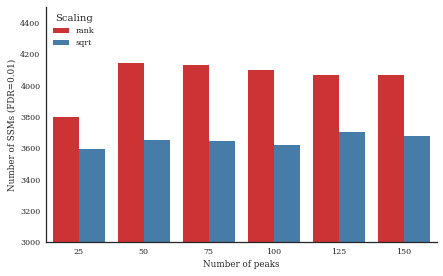

In [7]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

sns.barplot(x='num_peaks', y='psms', hue='scaling', data=psms, ax=ax)

# add numeric values above bars
# for p in ax.patches:
#     height = p.get_height()
#     ax.text(p.get_x() + p.get_width() / 2, height + 10,
#             '{:.0f}'.format(p.get_height()), ha='center') 

ax.set_xlabel('Number of peaks')
fdr = 0.01    # specified in the search settings
ax.set_ylabel('Number of SSMs (FDR={})'.format(fdr))
ax.set_ylim((3000, 4500))
legend = ax.legend(loc='upper left', title='Scaling')

sns.despine()

plt.savefig('preprocess.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

We can see that the maximum number of identifications (at 1% FDR) is achieved when using the 50 most intense peaks and scaling the intensities by their rank. This correspond to previously reported results by [Shao et al. (2013)](http://onlinelibrary.wiley.com/doi/10.1002/pmic.201300232/abstract).

In [8]:
logging.shutdown()